In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.client import device_lib
#check if gpu available
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# gpu memory
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

['/device:CPU:0', '/device:GPU:0']


# Load dataset

# InceptionV3

![image](./figures/inceptionv3.png)

# Recreating Inception model

**Source:**  
• https://github.com/pytorch/vision/blob/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models/inception.py  
• https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v3.py  
• https://www.youtube.com/watch?v=ekixid21Q5U  

All code is our own. We did write all of our code, and only used the above links as references on how the InceptionV3 model works and how to parametrize it. See utils/SE_inception_v3.py for the full code.


## CIFAR-10
### Without SE

In [3]:
from tensorflow.keras.utils import to_categorical  

#load cifar-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
#one hot encoding
y_test=to_categorical(y_test, num_classes=10)
y_train=to_categorical(y_train, num_classes=10)

#shuffle data and split data to generate validation data
shuffler = np.random.permutation(len(x_train))
x_train = x_train[shuffler]
y_train = y_train[shuffler]
 

#validation data
val_len = int(len(x_train)*0.2)
x_val=x_train[:val_len]
y_val=y_train[:val_len]

x_train=x_train[val_len:]
y_train=y_train[val_len:]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(40000, 32, 32, 3)
(40000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [33]:
from utils.train_CIFAR_all import *
from utils.SE_inception_v3 import inception_v3_custom

se_network=False # use or not an SE network
aux_classifier=True # use or not an auxiliary classifier; it is an intermediatary classifier in the model that is supposed to help reduce overfitting
data_base='cifar-10' # the database that we'll use
ratio = 16 # the r ratio of our SE network; authors recommand 16

inception_v3_cifar10 = inception_v3_custom(aux_classifier=aux_classifier, se_network=se_network, data_base= data_base, ratio = ratio)
inception_v3_model_cifar10 = inception_v3_cifar10.Model(name = 'inception_v3_model_cifar10')

inception_v3_model_cifar10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='categorical_crossentropy', metrics = ['acc'])

history_cifar10 = inception_v3_model_cifar10.fit(x= x_train, y = y_train,
                    epochs = 20,
                    validation_data=(x_val, y_val))

Epoch 1/20
1250/1250 [==============================] - 111s 82ms/step - loss: 4.3967 - auxiliary_classifier_loss: 2.5760 - prediction_layer_loss: 1.8207 - auxiliary_classifier_acc: 0.3708 - prediction_layer_acc: 0.3561 - val_loss: 3.3185 - val_auxiliary_classifier_loss: 1.7926 - val_prediction_layer_loss: 1.5259 - val_auxiliary_classifier_acc: 0.4737 - val_prediction_layer_acc: 0.4764
Epoch 2/20
1250/1250 [==============================] - 100s 80ms/step - loss: 2.6793 - auxiliary_classifier_loss: 1.4532 - prediction_layer_loss: 1.2260 - auxiliary_classifier_acc: 0.5647 - prediction_layer_acc: 0.5707 - val_loss: 2.4003 - val_auxiliary_classifier_loss: 1.2450 - val_prediction_layer_loss: 1.1552 - val_auxiliary_classifier_acc: 0.6063 - val_prediction_layer_acc: 0.5994
Epoch 3/20
1250/1250 [==============================] - 100s 80ms/step - loss: 2.1243 - auxiliary_classifier_loss: 1.1534 - prediction_layer_loss: 0.9709 - auxiliary_classifier_acc: 0.6549 - prediction_layer_acc: 0.6640 - 

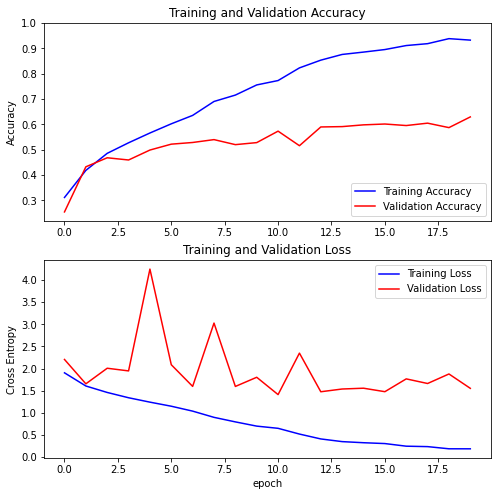

In [ ]:
plot_model_inception(history_cifar10)

In [ ]:
from utils.evaluate_model import score_inception
score_inception(inception_v3_model_cifar10, x_test, y_test, [1,3,5])

313/313 - 11s - loss: 0.2556 - auxiliary_classifier_loss: 0.1325 - prediction_layer_loss: 0.1231 - auxiliary_classifier_acc: 0.9549 - prediction_layer_acc: 0.9593
inception_v3_model_cifar10
model accuracy: 95.93%
top 1 accuracy: 95.92999815940857
top 3 accuracy: 99.87000226974487
top 5 accuracy: 99.95999932289124


In [ ]:
inception_v3_model_cifar10.summary()

Model: "inception_v3_model_cifar10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
tf.image.resize (TFOpLambda)    (None, 200, 200, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   896         tf.image.resize[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   128         conv2d[0][0]                     
_________________________________________________________________________

In [ ]:
checkpoint_path = "inception_v3_custom_cifar10.ckpt"

inception_v3_model_cifar10.save_weights(checkpoint_path)

#inception_v3_model_cifar10.load_weights(checkpoint_path)

### With SE

In [ ]:
from utils.train_CIFAR_all import *
from utils.SE_inception_v3 import inception_v3_custom

se_network=True # use or not an SE network
aux_classifier=True # use or not an auxiliary classifier; it is an intermediatary classifier in the model that is supposed to help reduce overfitting
data_base='cifar-10' # the database that we'll use
ratio = 16 # the r ratio of our SE network; authors recommand 16

se_inception_v3_cifar10 = inception_v3_custom(aux_classifier=aux_classifier, se_network=se_network, data_base= data_base, ratio = ratio)
se_inception_v3_model_cifar10 = se_inception_v3_cifar10.Model(name = 'se_inception_v3_model_cifar10')

se_inception_v3_model_cifar10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='categorical_crossentropy', metrics = ['acc'])

history_cifar10_se = se_inception_v3_model_cifar10.fit(x= x_train, y = y_train,
                    epochs = 20,
                    validation_data=(x_val, y_val))

Epoch 1/20
222/313 [====================>.........] - ETA: 7s - loss: 5.7888 - auxiliary_classifier_loss: 3.6718 - prediction_layer_loss: 2.1169 - auxiliary_classifier_acc: 0.2363 - prediction_layer_acc: 0.2189

KeyboardInterrupt: 

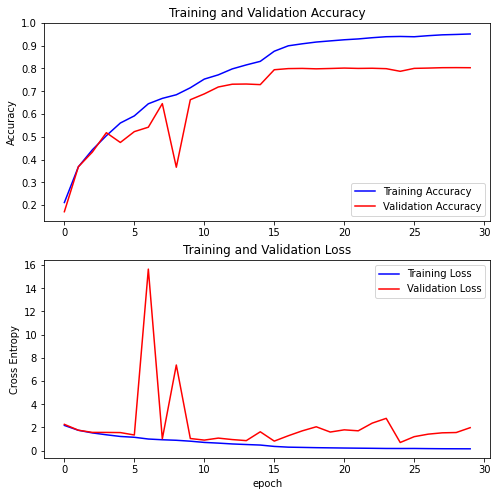

In [ ]:
plot_model_inception(history_cifar10_se)

In [ ]:
from utils.evaluate_model import score_inception
score_inception(se_inception_v3_model_cifar10, x_test, y_test, [1,3,5])

313/313 - 11s - loss: 1.5606 - acc: 0.4405
se_inception_v3_model_cifar10
model accuracy: 44.05%
top 1 accuracy: 44.04999911785126
top 3 accuracy: 77.96000242233276
top 5 accuracy: 91.39000177383423


In [ ]:
se_inception_v3_model_cifar10.summary()

Model: "se_inception_v3_model_cifar10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
tf.image.resize_1 (TFOpLambda)  (None, 200, 200, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 99, 99, 32)   896         tf.image.resize_1[0][0]          
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 99, 99, 32)   128         conv2d_96[0][0]                  
______________________________________________________________________

In [ ]:
checkpoint_path = "se_inception_v3_custom_cifar10.ckpt"

se_inception_v3_model_cifar10.save_weights(checkpoint_path)

#se_inception_v3_model_cifar10.load_weights(checkpoint_path)

## CIFAR-100
### Without SE

In [ ]:
from tensorflow.keras.utils import to_categorical  

#load cifar-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
#one hot encoding
y_test=to_categorical(y_test, num_classes=100)
y_train=to_categorical(y_train, num_classes=100)

#shuffle data and split data to generate validation data
shuffler = np.random.permutation(len(x_train))
x_train = x_train[shuffler]
y_train = y_train[shuffler]
 

#validation data
val_len = int(len(x_train)*0.2)
x_val=x_train[:val_len]
y_val=y_train[:val_len]

x_train=x_train[val_len:]
y_train=y_train[val_len:]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(40000, 32, 32, 3)
(40000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [ ]:
from utils.train_CIFAR_all import *
from utils.SE_inception_v3 import inception_v3_custom

se_network=False # use or not an SE network
aux_classifier=True # use or not an auxiliary classifier; it is an intermediatary classifier in the model that is supposed to help reduce overfitting
data_base='cifar-100' # the database that we'll use
ratio = 16 # the r ratio of our SE network; authors recommand 16

inception_v3_cifar100 = inception_v3_custom(aux_classifier=aux_classifier, se_network=se_network, data_base= data_base, ratio = ratio)
inception_v3_model_cifar100 = inception_v3_cifar100.Model(name = 'inception_v3_model_cifar100')

inception_v3_model_cifar100.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='categorical_crossentropy', metrics = ['acc'])

history_cifar100 = inception_v3_model_cifar100.fit(x= x_train, y = y_train,
                    epochs = 20,
                    validation_data=(x_val, y_val))

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
312/312 [==============================] - 99s 178ms/step - loss: 6.3486 - auxiliary_classifier_loss: 4.1188 - prediction_layer_loss: 2.2298 - auxiliary_classifier_acc: 0.1981 - prediction_layer_acc: 0.2136 - val_loss: 11.3635 - val_auxiliary_classifier_loss: 7.4390 - val_prediction_layer_loss: 3.9245 - val_auxiliary_classifier_acc: 0.3071 - val_prediction_layer_acc: 0.2877
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
312/312 [==============================] - 52s 165ms/step - loss: 3.7694 - auxiliary_classifier_loss: 2.0683 - prediction_layer_loss: 1.7011 - auxiliary_classifier_acc: 0.4123 - prediction_layer_acc: 0.4118 - val_loss: 2.9379 - val_auxiliary_classifier_loss: 1.4770 - val_prediction_layer_loss: 1.4608 - val_auxiliary_classifier_acc: 0.4454 - val_prediction_layer_acc: 0.4668
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing l

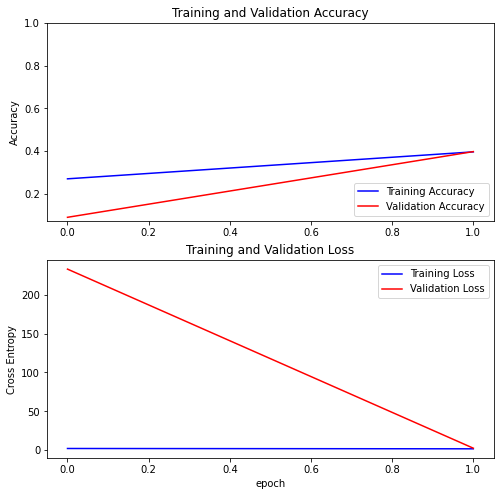

In [ ]:
plot_model_inception(history)

In [ ]:
inception_v3_model_cifar100.summary()

Model: "se_inception_v3_model_cifar10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
tf.image.resize_3 (TFOpLambda)  (None, 200, 200, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_213 (Conv2D)             (None, 99, 99, 32)   896         tf.image.resize_3[0][0]          
__________________________________________________________________________________________________
batch_normalization_212 (BatchN (None, 99, 99, 32)   128         conv2d_213[0][0]                 
______________________________________________________________________

In [ ]:
checkpoint_path = "inception_v3_custom_cifar100.ckpt"

inception_v3_model_cifar100.save_weights(checkpoint_path)

#inception_v3_model_cifar100.load_weights(checkpoint_path)

### With SE

In [ ]:
from utils.train_CIFAR_all import *
from utils.SE_inception_v3 import inception_v3_custom

se_network=True # use or not an SE network
aux_classifier=True # use or not an auxiliary classifier; it is an intermediatary classifier in the model that is supposed to help reduce overfitting
data_base='cifar-100' # the database that we'll use
ratio = 16 # the r ratio of our SE network; authors recommand 16

se_inception_v3_cifar100 = inception_v3_custom(aux_classifier=aux_classifier, se_network=se_network, data_base= data_base, ratio = ratio)
se_inception_v3_model_cifar100 = se_inception_v3_cifar100.Model(name = 'se_inception_v3_model_cifar100')

history = cifar_train(model = se_inception_v3_model_cifar100, path = '', X_train = x_train, y_train = y_train, X_val = x_val, y_val = y_val, learning_rate = 0.01, epochs = 30, epochs_schedule = [15,25])

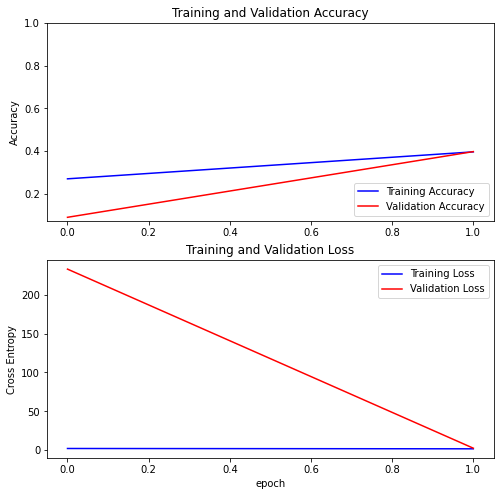

In [ ]:
plot_model_inception(history)

In [ ]:
from utils.evaluate_model import score
score(se_inception_v3_model_cifar100, x_test, y_test, [1,3,5])

In [ ]:
se_inception_v3_model_cifar100.summary()

In [ ]:
checkpoint_path = "se_inception_v3_custom_cifar100.ckpt"

se_inception_v3_model_cifar100.save_weights(checkpoint_path)

#se_inception_v3_model_cifar100.load_weights(checkpoint_path)